# Predict Selling Price of Old Vehicles

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from matplotlib import pyplot as plt
import seaborn as sns

print('Loaded')

Loaded


## Data Loading

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ujoshidev/Vechicle_PricePrediction/main/Dataset_Cardekho/car%20data.csv')
print(df.shape)
df.head()

(301, 9)


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


## Feature Engineering

In [ ]:
# Checking null/missing values 
print(df.isnull().sum().sum())
df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [ ]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [25]:
# Creating new feature Num_Years which will tell us vechical age. As per general rule, greater the age lesser the resale value.
from datetime import datetime # Used to get current date
df['Num_Years'] = datetime.today().year - df['Year']
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Num_Years
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,7
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,8
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,4
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,10
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,7


In [26]:
# Removing Year column as we will use Num_Years to predict the selling price. Also, dropping Car_Name feature as this is useless in prediction of resale price.

df.drop(['Car_Name','Year'],axis=1,inplace=True)
df.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Num_Years
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,7
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,8
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,4
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,10
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,7


In [37]:
# Converting catagorical features into numeric feature

## First checking unique catagories in each catagorical feature.
cat_cols = [c for c in df.columns if df[c].dtypes == 'object']
for c in cat_cols:
  print(df[c].unique())

## As number of unique catagories are very small. We will use One Hot Encoding for conversion.

print('Before OHE:')
df.head()
print('\nAfter OHE:')
df1 = pd.get_dummies(df[['Fuel_Type','Seller_Type','Transmission']],drop_first=True)
fin_df = df.join(df1)

## Dropping columns 'Fuel_Type','Seller_Type' & 'Transmission'.
fin_df.drop(['Fuel_Type','Seller_Type','Transmission'],axis=1,inplace=True)
fin_df.head()


['Petrol' 'Diesel' 'CNG']
['Dealer' 'Individual']
['Manual' 'Automatic']
Before OHE:

After OHE:


,Selling_Price,Present_Price,Kms_Driven,Owner,Num_Years,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,7,0,1,0,1
1,4.75,9.54,43000,0,8,1,0,0,1
2,7.25,9.85,6900,0,4,0,1,0,1
3,2.85,4.15,5200,0,10,0,1,0,1
4,4.60,6.87,42450,0,7,1,0,0,1


## EDA

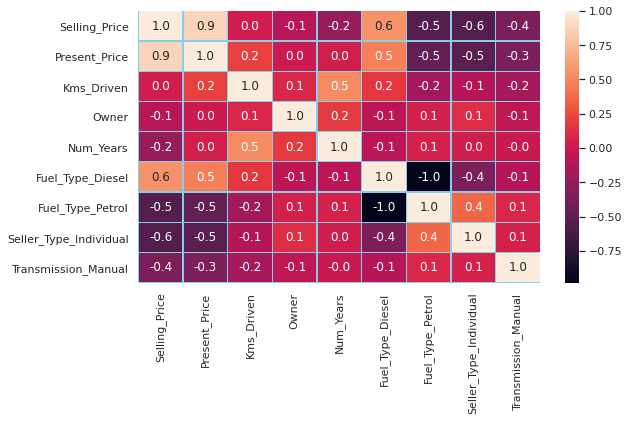

In [52]:
# define figure size
sns.set(rc={"figure.figsize":(9, 5)}) 
# correlation matrix using Pearson-correlation
sns.heatmap(fin_df.corr(),annot=True,fmt="1.1f",linewidths=0.2,linecolor='#87CEEB')

In [76]:
# Feature Importance
# from sklearn.ensemble import ExtraTreesRegressor

X = fin_df.iloc[:,1:]
y = fin_df.Selling_Price

model_etr = ExtraTreesRegressor()
model_etr.fit(X,y)

print(model_etr.feature_importances_)

[0.38671212 0.04157152 0.00109117 0.07657135 0.21439231 0.01489883
 0.12389673 0.14086597]


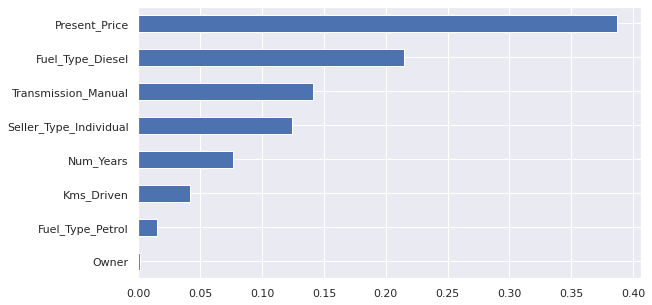

In [82]:
pd.Series(model_etr.feature_importances_,index=X.columns).sort_values().plot(kind='barh')

## Building ML model

In [111]:
# spliting data to training set and validation set
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape)

(240, 8) (240,) (61, 8) (61,)


### 1. Random Forest Regressor

In [112]:
# without Hyperparameter Tuning
model_rfr = RandomForestRegressor(n_estimators=200)
model_rfr.fit(X_train,y_train)
ypred_rfr = model_rfr.predict(X_valid)

print("r2 Score: ",r2_score(y_valid,ypred_rfr))
print("RMSE: ",mean_squared_error(y_valid,ypred_rfr,squared=False))

r2 Score:  0.9575426946087349
RMSE:  0.9889534098451066


In [93]:
# with Hyperparameter tuning

## Defining params
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1,scoring='neg_mean_squared_error',random_state=42)

# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished


{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


r2 Score:  0.9625329592686878
RMSE:  0.9290183978217544


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


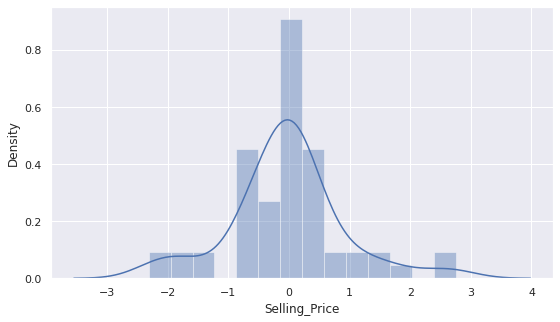

In [99]:
# best params: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}

ypred_rfr = rf_random.predict(X_valid)

print("r2 Score: ",r2_score(y_valid,ypred_rfr))
print("RMSE: ",mean_squared_error(y_valid,ypred_rfr,squared=False))


sns.distplot(y_valid-ypred_rfr)

In [113]:
# using selective params with order returned by best_params_ 

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 15, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 6, 10] # Minimum number of samples required at each leaf node

random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features':max_features,
               'max_depth': max_depth
               }
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=2, n_jobs = -1,scoring='neg_mean_squared_error',random_state=42)


# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40}


r2 Score:  0.9566447237113924
RMSE:  0.9993568588581142


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


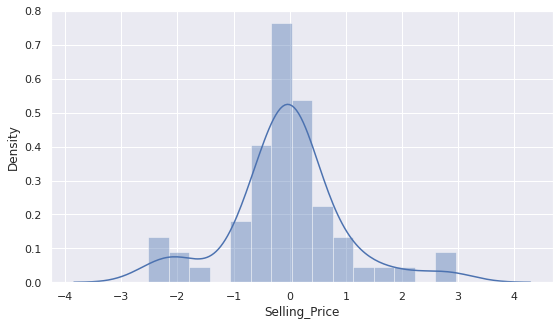

In [114]:
ypred_rfr_final = rf_random.predict(X_valid)

print("r2 Score: ",r2_score(y_valid, ypred_rfr_final))
print("RMSE: ",mean_squared_error(y_valid, ypred_rfr_final, squared=False))


sns.distplot(y_valid-ypred_rfr_final)

In [115]:
import pickle

file=open('random_forest_regression_model.pkl','wb') #file where you want to store data

pickle.dump(rf_random,file)

In [117]:
!pip install flask
!pip install jsonify

  Created wheel for jsonify: filename=jsonify-0.5-py3-none-any.whl size=1562 sha256=7d7e6964559217eb7e0cfbbb642200345e6a214e5be1d9b4af0b3bfb10dfd149
  Stored in directory: /root/.cache/pip/wheels/a7/15/e0/a5eb19cf0496a9ea2bddb0c9f1dc324559385806b75400988b
Successfully built jsonify
